In [3]:
# Import the neccessary libraries 

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

 # 11,48,626
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords

from time import time

import warnings
warnings.filterwarnings("ignore")

import logging
import traceback

# Configure logging
logging.basicConfig(filename='text_classification.log', level=logging.INFO, format='%(asctime)s %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

Text Classification 

The dataset chosen consists of about 8000 rows and 15 columns, with texts related to the US Politics, The column 'relevant' consists of Binary values YES or NO depicting if the Text is relevant to the context.
A third class stating 'NOT SURE' is also represented but has been dropped due to inadequate number of values(only 9 out of 8000). 

The data is highly imbalanced with 6.5k relevant articles, and 1.4 irrelavant articles. 

EDA

In [4]:
df = pd.read_csv('US-Economic-News.csv', encoding = 'ISO-8859-1')
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [5]:
df['relevance'].value_counts()

relevance
no          6571
yes         1420
not sure       9
Name: count, dtype: int64

In [6]:
# dropping the third class as it is highly unbalanced and not required for the context

df = df[df.relevance != "not sure"]
df.shape

(7991, 15)

In [7]:
try:
    logger.info("Dataset created with relevant columns")
    data = df[["text","relevance"]] # taking text input and output variable as relevance
    data['relevance'] = data['relevance'].map({'yes':1, 'no':0}) # Mapping relevant as 1, not-relevant as 0 
    logger.info(data.shape)

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    logger.error(traceback.format_exc())


In [8]:
data

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1
...,...,...
7995,Secretary of Commerce Charles W. Sawyer said y...,1
7996,"U.S. stocks inched up last week, overcoming co...",0
7997,Ben S. Bernanke cleared a key hurdle Thursday ...,0
7998,The White House's push to contract out many fe...,0


In [9]:
data['text'][0] #Understanding the neccesary text cleaning to be done by examining a single article 

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [10]:
data['text'][3]

'The statistics on the enormous costs of employee drug abuse are well known (at least $70 billion per year, according to December 1985 testimony before the House Labor Subcommittee on Health and Safety). Management is under pressure to reduce productivity losses, turnover, insurance costs and the risk of lawsuits for personal and property damage caused by drug-impaired workers. Management also is under sales pressure from a growing cadre of laboratories, test-kit manufacturers and consultants who extol the virtues of testing. A common argument is the following: "Your competitors are starting to require drug tests. If you don\'t, their work force will be clean and you will end up with all the junkies."</br></br>Many companies that have implemented widespread drug-testing programs, however, have learned that there is a downside to testing. They have experienced the protests of employees and civil libertarians and have watched the proliferation of lawsuits alleging invasion of privacy, de

Data Cleaning 

In [19]:

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# NLP preprocessing has been implemented lower stopwords removal, lemmatisation, lowering cases. 
def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        # if item.text in ents:
        #     pass
        # else:
        text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))
    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [20]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,washington effort achieve banking reform senat...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar tone traders...,1


In [21]:
data['text'][0]

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term interest rates br small denomination consumer cds sold directly banks average yield six month deposits fell week ended yesterday according bank survey banxquote money markets wilmington del information service br three month consumer deposits average yield sank week according banxquote two banks banxquote survey citibank new york corestates pennsylvania paying less threemonth small denomination cds br declines somewhat smaller five year consumer cds eased banxquote said br yields three month six month treasury bills sold monday auction plummeted fifth percentage point previous week respectively'

Feature Extraction - TFIDF 

In [14]:
# Applying TFIDF Vectoriser to form the vector array from the textual data
logger.info("Initiating the process of Vectorisation")
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
logger.info('Vectorising process completed: Vectors', tfidf_vectorizer_vectors)
docs = tfidf_vectorizer_vectors.toarray()

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

In [15]:
x = docs 
y = data['relevance']
print(x.shape, y.shape)

(7991, 20000) (7991,)


DATASET PREP FOR TRAINING

In [16]:
# Splitting the data into 8:2 ratio 
try:
    logger.info("Splitting the Data")
    SEED=123
    x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=SEED, stratify=y)
    logger.info("Splitting process has been complted-Shapes of the data", x_train.shape, y_train.shape,x_test.shape, y_test.shape) 

except Exception as e:
    logger.error(f"An error occurred: {str(e)}")
    logger.error(traceback.format_exc())


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

In [17]:
# Function for Evaluation 

def evaluation(model_name, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test):
    try:
    # Using the model to predict
        logger.info(f"Fitting the {model_name} model to the Data")
        model = model_name
        model.fit(x_train, y_train)
        y_pred_test = model.predict(x_test)
        logger.info("Testing Accuracy score:", accuracy_score(y_test, y_pred_test))
        print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
        # Classification Report of the Model
        print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))
        logger.info("Classification Report", classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))
        #Confusion Matrix for the Model
        cm = confusion_matrix(y_test, y_pred_test)
        cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'], 
                                index=['Predict Positive', 'Predict Negative'])
        sns.heatmap(cm_matrix, annot=True, fmt='d')
        plt.show()
        #ROC-AUC Curve
        probs = model.predict_proba(x_test)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
    except Exception as e:
        logger.error(f"An error occurred: {str(e)}")
        logger.error(traceback.format_exc())


    return
    

Checking different models on the Raw Data

1. Guassian Naive Bayes - The model was successful in giving a good accuracy of 78.5%. However when we observe the Classification report, There is a huge difference in the F1-Score of class 1 and class 2. Model has perfomed well on the heavily weighed data, but for the class with less data score is lesser

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

Testing Accuracy score: 0.7892432770481551
              precision    recall  f1-score   support

not relevant       0.84      0.92      0.88      1315
    relevant       0.32      0.17      0.23       284

    accuracy                           0.79      1599
   macro avg       0.58      0.55      0.55      1599
weighted avg       0.75      0.79      0.76      1599



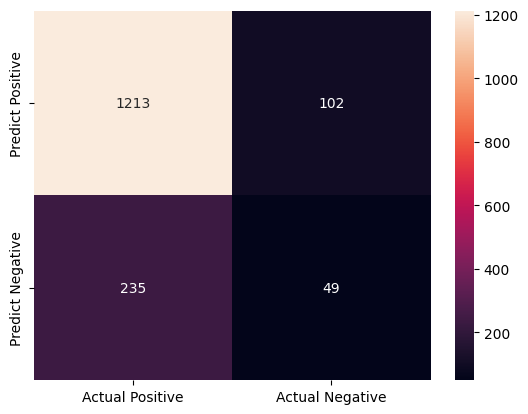

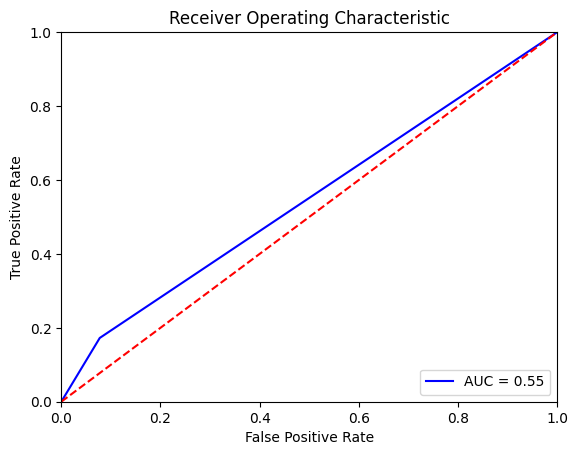

In [18]:
evaluation(GaussianNB())

2. Logistic Regression - The model is quite complex when compared to the Naive Bayes and by including class_weights parameter the model has to exprectedly penalise the majority data and form a balance. Hence, we notice that the model was successful in giving a good accuracy of 82.3%. However when we observe the Classification report, There is a huge difference in the F1-Score of class 1 and class 2. Model has overfitted on majority data. But the evaluation in ROC-AUC Curve shows a good difference between true positives and False posiitves 



Testing Accuracy score: 0.8223889931207005
              precision    recall  f1-score   support

not relevant       0.83      0.98      0.90      1315
    relevant       0.50      0.09      0.15       284

    accuracy                           0.82      1599
   macro avg       0.67      0.54      0.53      1599
weighted avg       0.77      0.82      0.77      1599



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

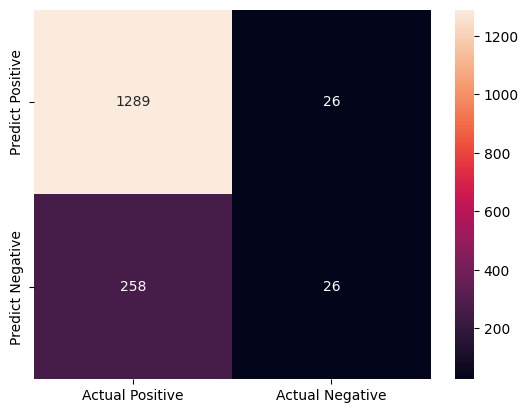

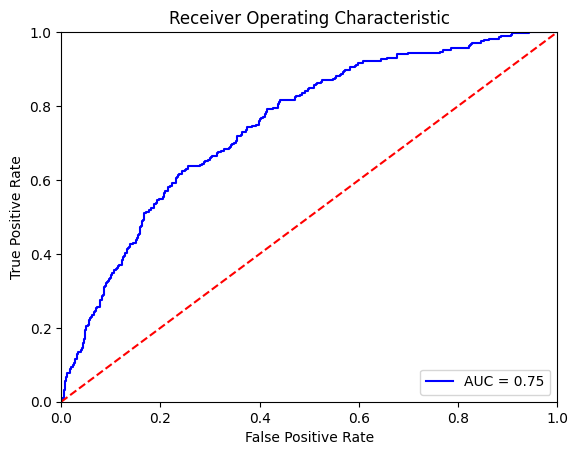

In [26]:
evaluation(LogisticRegression(random_state=SEED))

Testing Accuracy score: 0.8223889931207005
              precision    recall  f1-score   support

not relevant       0.82      1.00      0.90      1315
    relevant       0.00      0.00      0.00       284

    accuracy                           0.82      1599
   macro avg       0.41      0.50      0.45      1599
weighted avg       0.68      0.82      0.74      1599



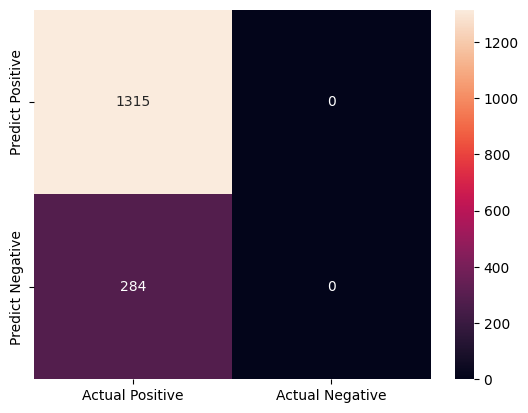

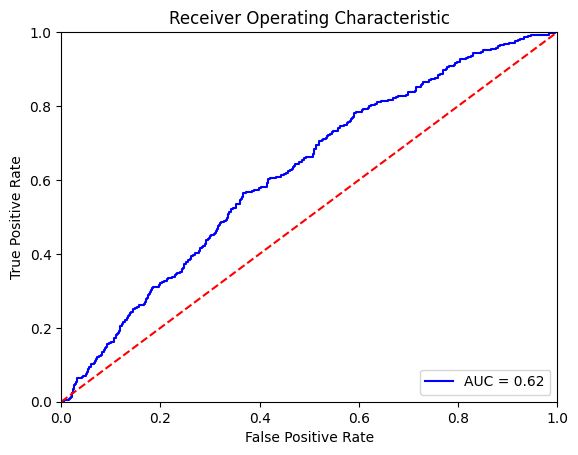

In [20]:
evaluation(MultinomialNB())

Handling the class Imbalance 

1. SMOTE - It is a technique to handle the imbalanced dataset by oversampling the minority class. Initially we observe hig variations in the classes (relevant articles and irrelevant articles) which is handles with SMOTE

In [27]:
y.value_counts()

relevance
0    6571
1    1420
Name: count, dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(x,y)

In [29]:
y_sm.value_counts()

relevance
1    6571
0    6571
Name: count, dtype: int64

In [30]:
x_train_sm,x_test_sm,y_train_sm,y_test_sm=train_test_split(x_sm, y_sm, test_size=0.2, random_state=SEED, stratify=y_sm)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6392, 20000) (6392,)
(1599, 20000) (1599,)


Applying the Model with Oversampled Data

1. GuassianNB -Here in this case we have observed that the evaluation results are well balanced 

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

Testing Accuracy score: 0.9437048307341195
              precision    recall  f1-score   support

not relevant       0.99      0.90      0.94      1315
    relevant       0.90      0.99      0.95      1314

    accuracy                           0.94      2629
   macro avg       0.95      0.94      0.94      2629
weighted avg       0.95      0.94      0.94      2629



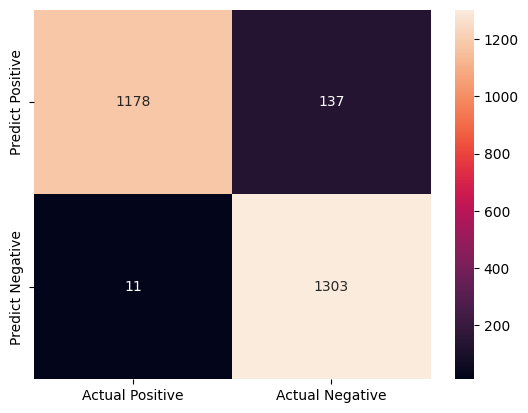

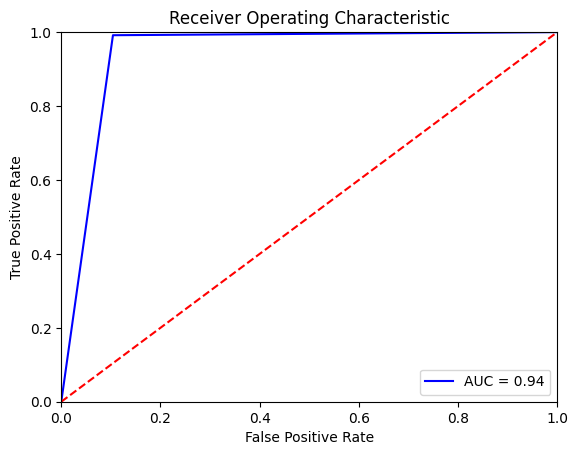

In [31]:
evaluation(GaussianNB(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

MultinomialNB

Testing Accuracy score: 0.7668314948649677
              precision    recall  f1-score   support

not relevant       0.86      0.64      0.73      1315
    relevant       0.71      0.90      0.79      1314

    accuracy                           0.77      2629
   macro avg       0.79      0.77      0.76      2629
weighted avg       0.79      0.77      0.76      2629



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

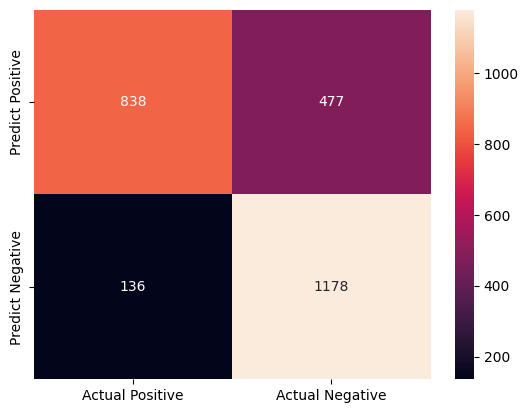

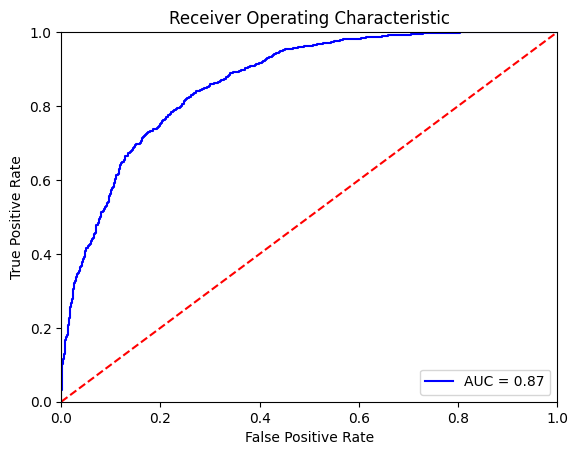

In [32]:
evaluation(MultinomialNB(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

Logistic Regression 

Testing Accuracy score: 0.8352985926207683
              precision    recall  f1-score   support

not relevant       0.86      0.80      0.83      1315
    relevant       0.81      0.87      0.84      1314

    accuracy                           0.84      2629
   macro avg       0.84      0.84      0.84      2629
weighted avg       0.84      0.84      0.84      2629



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

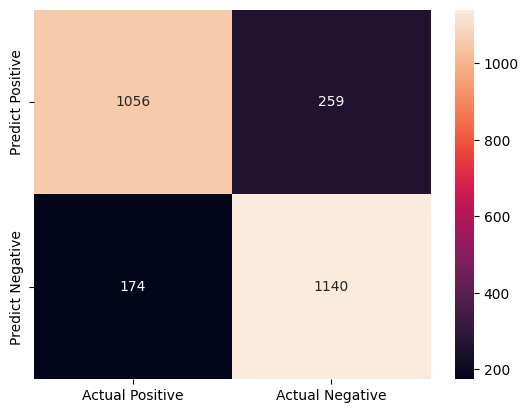

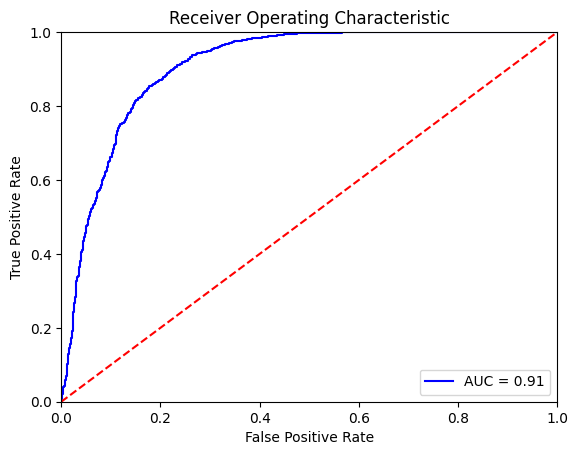

In [33]:
evaluation(LogisticRegression(), x_train=x_train_sm, y_train=y_train_sm, x_test=x_test_sm, y_test=y_test_sm)

2. Ensembling - Here we divide the majority data into smaller groups to match with the minority data, apply the specified model for each samples and processed the average evaluation results for the same

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=15, stratify=y)

In [35]:
y_train.value_counts()

relevance
0    5256
1    1136
Name: count, dtype: int64

In [36]:
df_class0 = data[data.relevance==0]
df_class1 = data[data.relevance==1]

In [37]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)
    x_train = df_train.text
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(x_train)
    x_train = tfidf_vectorizer_vectors.toarray()
    y_train = df_train.relevance
    return x_train, y_train   

In [38]:
x_train_en, y_train_en = get_train_batch(df_class0, df_class1, 0, 1136)

In [39]:
x_train_en.shape

(2556, 20000)

In [40]:
y_train_en.value_counts()

relevance
1    1420
0    1136
Name: count, dtype: int64

Logistic Regression

Testing Accuracy score: 0.8217636022514071
              precision    recall  f1-score   support

not relevant       0.82      1.00      0.90      1315
    relevant       0.00      0.00      0.00       284

    accuracy                           0.82      1599
   macro avg       0.41      0.50      0.45      1599
weighted avg       0.68      0.82      0.74      1599



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

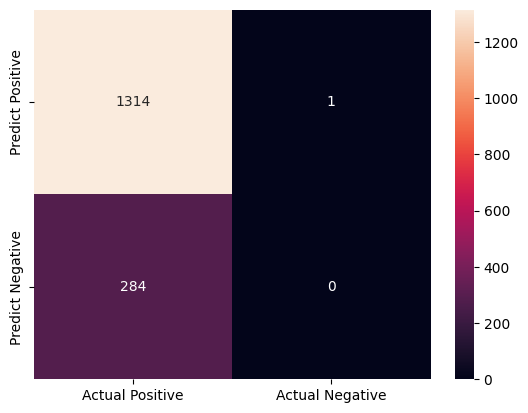

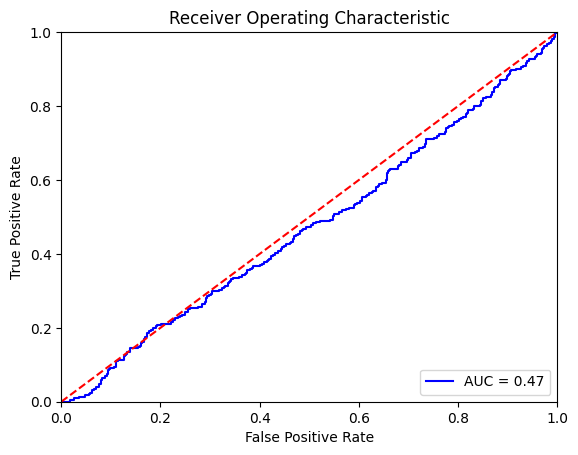

In [41]:
evaluation(LogisticRegression(random_state=SEED), x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test )

GuassianNB

Testing Accuracy score: 0.5684803001876173
              precision    recall  f1-score   support

not relevant       0.80      0.63      0.71      1315
    relevant       0.14      0.27      0.18       284

    accuracy                           0.57      1599
   macro avg       0.47      0.45      0.45      1599
weighted avg       0.68      0.57      0.61      1599



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

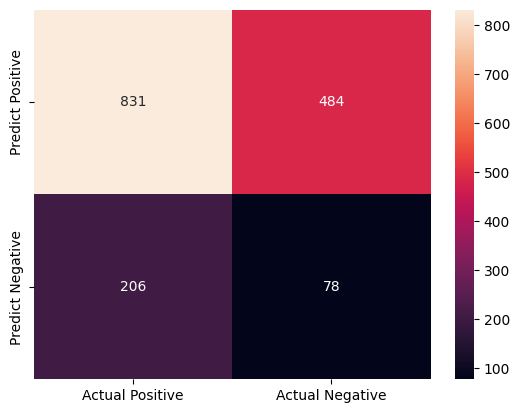

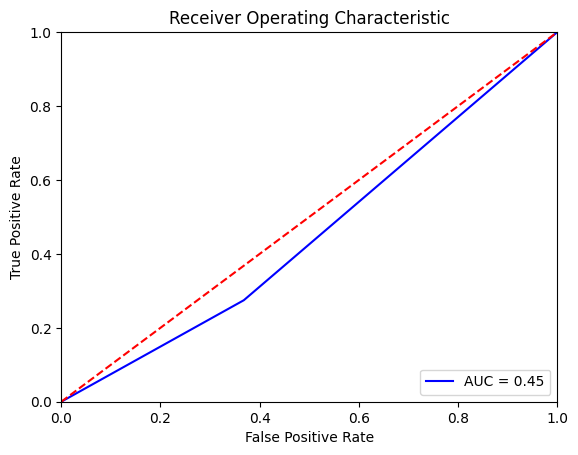

In [42]:
evaluation(GaussianNB(),  x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test)

MutlinomialNB

Testing Accuracy score: 0.776735459662289
              precision    recall  f1-score   support

not relevant       0.82      0.94      0.87      1315
    relevant       0.12      0.04      0.06       284

    accuracy                           0.78      1599
   macro avg       0.47      0.49      0.47      1599
weighted avg       0.70      0.78      0.73      1599



--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

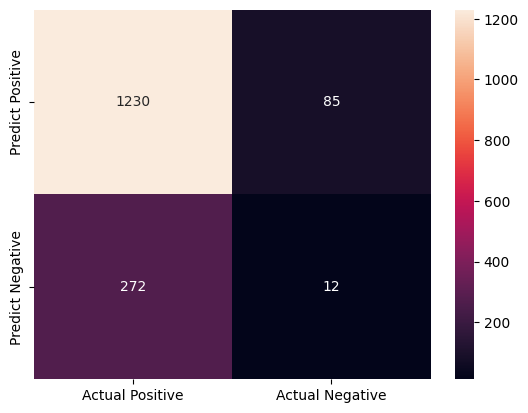

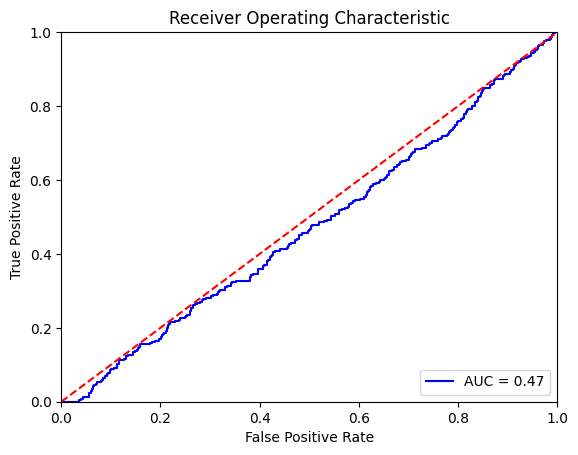

In [43]:
evaluation(MultinomialNB(),  x_train=x_train_en, y_train=y_train_en, x_test=x_test, y_test=y_test)

Expectation - ensembling is also a technique to handle the imblanced data however in the case it has performed poorly fo the base models considered. 


Hyperparamter Tuning

In [44]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [45]:
# Define base classifiers
c1 = LogisticRegression()
c2 = GaussianNB() 
# c3 = MultinomialNB()

In [46]:
#  a voting classifier
voting_clf = VotingClassifier(estimators=[('lr', c1), ('gnb', c2)], voting='soft')

In [47]:
param_grid = {
    'lr__C': [0.1, 1, 10, 100],
    'lr__solver': ['liblinear', 'lbfgs'],
    'lr__max_iter': [100, 200, 300],
    'gnb__priors': [None],  # GaussianNB parameters
    # 'mnb__alpha': [0.1, 0.5, 1.0, 2.0]  # MultinomialNB parameter
}


In [48]:
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(x_sm, y_sm)


GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('lr',
                                                     LogisticRegression()),
                                                    ('gnb', GaussianNB())],
                                        voting='soft'),
             param_grid={'gnb__priors': [None], 'lr__C': [0.1, 1, 10, 100],
                         'lr__max_iter': [100, 200, 300],
                         'lr__solver': ['liblinear', 'lbfgs']},
             scoring='f1')

In [49]:
print("Best parameters found: ", grid_search.best_params_)
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

Best parameters found:  {'gnb__priors': None, 'lr__C': 0.1, 'lr__max_iter': 100, 'lr__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1315
           1       0.71      1.00      0.83       284

    accuracy                           0.93      1599
   macro avg       0.85      0.96      0.89      1599
weighted avg       0.95      0.93      0.93      1599



In [ ]:
print('y actual : \n' +  str(y_test.value_counts()))
#Distribution of y predicted
print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tr4\AppData\Local\Programs\Python\Python312\Lib\logging\__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\tr4\AppData\Roaming\Python\Python312\site-packages\ipykernel

Testing Accuracy score: 0.9212007504690432
              precision    recall  f1-score   support

not relevant       1.00      0.91      0.95      1315
    relevant       0.70      0.99      0.82       284

    accuracy                           0.92      1599
   macro avg       0.85      0.95      0.88      1599
weighted avg       0.94      0.92      0.93      1599



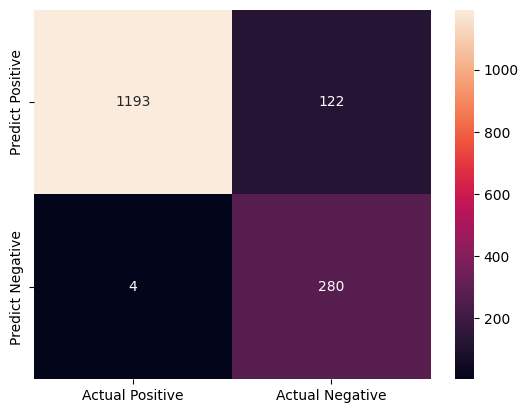

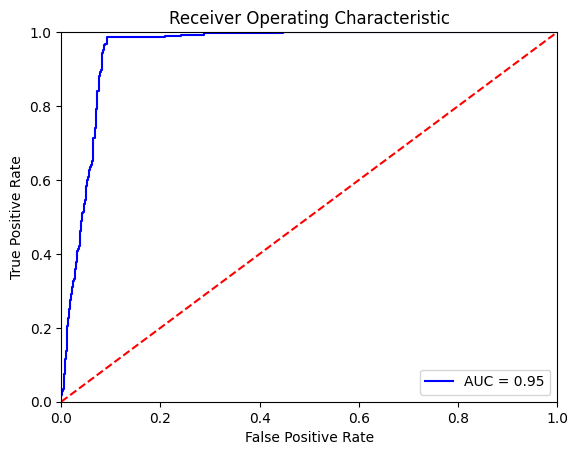

In [50]:
evaluation(grid_search, x_train=x_train_sm, y_train=y_train_sm, x_test=x_test, y_test=y_test)